# Explore Tall's Puget Sound O2 Obs Datasets

Exploration of one of the Puget Sound dissolved O2 datasets that Tall obtained from
http://nwem.apl.washington.edu/erddap/

In [1]:
from pathlib import Path

import arrow
from matplotlib import pyplot as plt
import xarray

from salishsea_tools import geo_tools

Paths to collection of obs datasets,
and to a specific dataset:

In [2]:
obs_dir = Path("/ocean/atall/MOAD/Obs/PugetSound/ERDDAP/")
obs_file = obs_dir / "L2_gridded_025_TW_20070101-20071231.nc"

Load and display the dataset so we can learn about its structure:

In [3]:
obs_ds = xarray.open_dataset(obs_file)
obs_ds

<xarray.Dataset>
Dimensions:                                           (cast_start_time: 2878,
                                                       sea_water_pressure: 141)
Coordinates:
  * cast_start_time                                   (cast_start_time) datetime64[ns] ...
  * sea_water_pressure                                (sea_water_pressure) float64 ...
Data variables:
    sea_water_temperature                             (cast_start_time, sea_water_pressure) float64 ...
    sea_water_practical_salinity                      (cast_start_time, sea_water_pressure) float64 ...
    sea_water_sigma_theta                             (cast_start_time, sea_water_pressure) float64 ...
    depth                                             (cast_start_time, sea_water_pressure) float64 ...
    mass_concentration_of_chlorophyll_a_in_sea_water  (cast_start_time, sea_water_pressure) float64 ...
    mole_concentration_of_nitrate_in_sea_water        (cast_start_time, sea_water_pressure) float64 ...
    mass_concentration_of_oxygen_in_sea_water         (cast_start_time, sea_water_pressure) float64 ...
Attributes: (12/30)
    author:                    Seth Travis
    buoy_designation:          ORCA1
    buoy_latitude:             47.375 degrees N
    buoy_longitude:            -123.00833333 degrees E
    buoy_name:                 Twanoh
    buoy_reference_number:     1
    ...                        ...
    license:                   The data may be used and redistributed for fre...
    sourceUrl:                 (local files)
    standard_name_vocabulary:  CF Standard Name Table v70
    summary:                   The Northwest Environmental Moorings program m...
    title:                     ORCA1 - Twanoh - L2 Pressure Gridded Data - 0....
    water_depth:               35 meters

`cast_start_time` is the time coordinate we have to work with.
How are the cast times organized?


In [4]:
obs_ds.cast_start_time[:5]

<xarray.DataArray 'cast_start_time' (cast_start_time: 5)>
array(['2007-01-01T05:00:41.000000000', '2007-01-01T17:00:41.000000000',
       '2007-01-02T05:00:42.000000000', '2007-01-02T17:00:43.000000000',
       '2007-01-03T17:00:01.000000000'], dtype='datetime64[ns]')
Coordinates:
  * cast_start_time  (cast_start_time) datetime64[ns] 2007-01-01T05:00:41 ......
Attributes:
    actual_range:   [1.16762764e+09 1.19916364e+09]
    description:    Start time of cast, based on number of days since the def...
    ioos_category:  Time
    long_name:      cast start time
    standard_name:  time
    time_origin:    01-JAN-1970 00:00:00
    timezone:       UTC

It looks like a cast starts nominally every 12 hours at 05:00 and 17:00 UTC.
But the fact that there are 2878 values of `cast_start_time` suggests that the
frequency may be higher that twice daily during some parts of the year.

Now, let's look at the depths at which obs were collected during a specific cast:

In [5]:
obs_ds.depth.sel(cast_start_time=obs_ds.cast_start_time[0])

<xarray.DataArray 'depth' (sea_water_pressure: 141)>
[141 values with dtype=float64]
Coordinates:
    cast_start_time     datetime64[ns] 2007-01-01T05:00:41
  * sea_water_pressure  (sea_water_pressure) float64 0.0 0.25 0.5 ... 34.75 35.0
Attributes:
    colorBarMaximum:  35.0
    colorBarMinimum:  0.0
    colorBarPalette:  TopographyDepth
    description:      Z-coordinate of observation in vertical distance below ...
    ioos_category:    Location
    long_name:        depth
    references:       UNESCO 1983 - Pressure to Depth Conversion
    standard_name:    depth
    units:            m

The array of depth values is accessible via the `data` attribute:

In [6]:
obs_ds.depth.sel(cast_start_time=obs_ds.cast_start_time[0]).data

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,  1.73046154,  1.98438095,  2.23139355,
        2.48028889,  2.72643226,  2.94419444,  3.19525   ,  3.49983065,
        3.71809474,  3.96650476,  4.21412881,  4.43342857,  4.70998667,
        4.95365625,  5.23635714,  5.4557193 ,  5.70066129,  5.95226667,
        6.19671667,  6.44751481,  6.69403226,  6.9406    ,  7.18826154,
        7.43630526,  7.68355294,  7.93445517,  8.18206316,  8.42965556,
        8.67915172,  8.92515254,  9.1733931 ,  9.41888966,  9.66732143,
        9.91572258, 10.16325161, 10.41241639, 10.66163051, 10.92140923,
       11.15441481, 11.40429655, 11.64794909, 11.90027368, 12.14649231,
       12.39255294, 12.64414074, 12.89189677, 13.13601017, 13.38615862,
       13.63514483, 13.88452143, 14.131     , 14.38054   , 14.6259    ,
       14.87563077, 15.12191429, 15.3704    , 15.61833103, 15.86556429,
       16.11453962, 16.36102593, 16.61045455, 16.85954286, 17.10

Rather than messing around with indexing in the the `cast_start_time` data array,
we can let the `sel()` method find the nearest cast time to a NEMO model time.
The SalishSeaCast NEMO model hourly results are hour-averages centered on the half hour.
They are on UTC time as are the observations.
So, this is an easy way to match observations to model results time points:

In [7]:
obs_depths = obs_ds.depth.sel(cast_start_time="2007-01-01 05:30:00", method="nearest")
obs_depths

<xarray.DataArray 'depth' (sea_water_pressure: 141)>
[141 values with dtype=float64]
Coordinates:
    cast_start_time     datetime64[ns] 2007-01-01T05:00:41
  * sea_water_pressure  (sea_water_pressure) float64 0.0 0.25 0.5 ... 34.75 35.0
Attributes:
    colorBarMaximum:  35.0
    colorBarMinimum:  0.0
    colorBarPalette:  TopographyDepth
    description:      Z-coordinate of observation in vertical distance below ...
    ioos_category:    Location
    long_name:        depth
    references:       UNESCO 1983 - Pressure to Depth Conversion
    standard_name:    depth
    units:            m

The same technique works for the measured obs values:

In [8]:
obs_sw_temps = obs_ds.sea_water_temperature.sel(cast_start_time="2007-01-01 05:30:00", method="nearest")
obs_sw_temps

<xarray.DataArray 'sea_water_temperature' (sea_water_pressure: 141)>
[141 values with dtype=float64]
Coordinates:
    cast_start_time     datetime64[ns] 2007-01-01T05:00:41
  * sea_water_pressure  (sea_water_pressure) float64 0.0 0.25 0.5 ... 34.75 35.0
Attributes:
    colorBarMaximum:  25.0
    colorBarMinimum:  5.0
    description:      In-situ temperature of water (T90 scale)
    ioos_category:    Temperature
    long_name:        Sea Water Temperature
    standard_name:    sea_water_temperature
    units:            degree_C

With that, we can do a profile plot on the obs water temperature:

Text(0.5, 0, 'Sea Water Temperature [degree_C]')

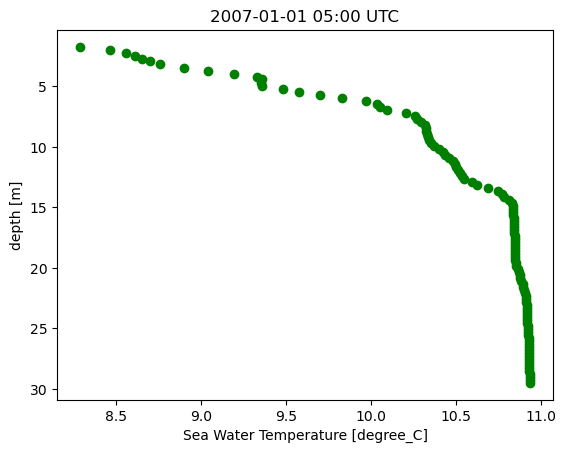

In [9]:
fig, ax = plt.subplots(1, 1)
ax.scatter(obs_sw_temps, obs_depths, color="g")
ax.invert_yaxis()
profile_time = arrow.get(str(obs_sw_temps.cast_start_time.data))
ax.set_title(profile_time.format("YYYY-MM-DD HH:mm UTC"))
ax.set_ylabel(f"{obs_depths.long_name} [{obs_depths.units}]")
ax.set_xlabel(f"{obs_sw_temps.long_name} [{obs_sw_temps.units}]")

## Matching Obs Profiles to SalishSeaCast NEMO Profiles

Now we want to compare the cast obs to NEMO model output.
To do that we need to:

* find the NEMO model grid point that is closest to the cast lon/lat
* check the distance of the model grid point from the cast location
* load the depth profile from the NEMO output
* interpolate the NEMO results to the obs depths

Get lon/lat of obs cast.
This takes some fiddling around because they are stored in strings in the dataset attributes.

In [ ]:
obs_lon = obs_ds.attrs["buoy_longitude"]
obs_lon

'-123.00833333 degrees E'

In [ ]:
obs_lon = float(obs_lon.split(" ", maxsplit=1)[0])
obs_lon

-123.00833333

In [ ]:
obs_lat = obs_ds.attrs["buoy_latitude"]
obs_lat = float(obs_lat.split(" ", maxsplit=1)[0])
obs_lat

47.375

Our `salishsea_tools` package contains a function to find the closest model grid point
to a specified lon/lat. Docs are at 
https://salishsea-meopar-tools.readthedocs.io/en/latest/SalishSeaTools/api.html#salishsea_tools.geo_tools.find_closest_model_point. 
However, it is quite slow.
So, while it is a general solution, the problem of finding a NEMO model grid point near an observation location arises often enough
that Susan used that function to create a mapping file that can be used to look up the nearest grid point to a lon/lat.
That mapping files is https://github.com/SalishSeaCast/grid/blob/main/grid_from_lat_lon_mask999.nc.

If you haven't already done so, clone the `SalishSeaCast/grid` repository beside your analysis repository; e.g.
```
cd /ocean/atall/MOAD/
git clone git@github.com:SalishSeaCast/grid.git
```

Load the model grid lons/lats mapping:

In [17]:
grid_dir = Path("/SalishSeaCast/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")


In [18]:
grid_lons_lats = xarray.open_dataset(grid_dir / grid_map)
grid_lons_lats

<xarray.Dataset>
Dimensions:  (lons: 9605, lats: 13585)
Coordinates:
  * lons     (lons) float64 -126.4 -126.4 -126.4 -126.4 ... -121.3 -121.3 -121.3
  * lats     (lats) float64 46.86 46.86 46.86 46.86 ... 51.1 51.1 51.1 51.1
Data variables:
    jj       (lats, lons) int16 ...
    ii       (lats, lons) int16 ...
Attributes:
    acknowledgements:      Based on find_closest point
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 Grid position from lat/lons
    history:               [2021-02-25] File creation.
    Mask:                  from geometry and then corrected based on results,...

In [31]:
obs_j_da = grid_lons_lats.jj.sel(lats=obs_lat, lons=obs_lon, method='nearest')
obs_j_da


<xarray.DataArray 'jj' ()>
[1 values with dtype=int16]
Coordinates:
    lons     float64 -123.0
    lats     float64 47.37
Attributes:
    units:      grid cells in NEMO SalishSeaCst
    long_name:  long strait grid

Extract the `obs_j` value from the `DataArray` with the `item()` method:

In [32]:
obs_j = obs_j_da.item()
obs_j

72

Similarly for `obs_i`:

In [33]:
obs_i_da = grid_lons_lats.ii.sel(lats=obs_lat, lons=obs_lon, method='nearest')
obs_i = obs_i_da.item()
obs_i

123

As a check, we can calculate the distance (in km) between the model grid point lon/lat
and the obj lon/lat with the `salishsea_tools.geo_tools.haversine()` function:

In [35]:
geo_tools.haversine(obs_j_da.lons, obs_j_da.lats, obs_lon, obs_lat)

<xarray.DataArray ()>
array(0.00995443)
Coordinates:
    lons     float64 -123.0
    lats     float64 47.37

Less than 10m! Nice!

Now let's get the model temperature profile at the grid point nearest to the cast location.

This is the way accessing a 1-day file of hour-averaged model results.
We'll use `Reshapr` to extract profiles for multiple days in 1 file later.

In [37]:
model_dir = Path("/results2/SalishSea/nowcast-green.202111/")
model_file = Path("01jan07", "SalishSea_1h_20070101_20070101_grid_T.nc")

In [38]:
model_ds = xarray.open_dataset(model_dir / model_file)
model_ds

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, nvertex: 4, deptht: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2007-01-01T00:30:00 ....
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    votemper              (time_counter, deptht, y, x) float32 ...
    vosaline              (time_counter, deptht, y, x) float32 ...
    sigma_theta           (time_counter, deptht, y, x) float32 ...
    e3t                   (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         SalishSea_1h_20070101_20070105
    description:  physics tracers and VVL layer thicknesses
    title:        physics tracers and VVL layer thicknesses
    Conventions:  CF-1.6
    timeStamp:    2022-Oct-24 21:24:51 GMT
    uuid:         4a8ebbb4-f129-4b42-bcde-4004b6cb9b4a

In [60]:
model_temp_profile = model_ds.votemper.sel(time_counter="2007-01-01 05:30:00", y=obs_j, x=obs_i)
model_temp_profile

<xarray.DataArray 'votemper' (deptht: 40)>
[40 values with dtype=float32]
Coordinates:
    nav_lat        float32 ...
    nav_lon        float32 ...
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2007-01-01T05:30:00
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           Conservative Temperature
    units:               degree_C
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

Let's select only the model depths that are less than or equal to the maximum obs depth:

In [61]:
obs_depths_mask = model_temp_profile.deptht<=obs_depths.max()
obs_depths_mask


<xarray.DataArray (deptht: 40)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])
Coordinates:
    nav_lat          float32 ...
    nav_lon          float32 ...
  * deptht           (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered    datetime64[ns] ...
    time_counter     datetime64[ns] 2007-01-01T05:30:00
    cast_start_time  datetime64[ns] 2007-01-01T05:00:41

In [62]:
model_temp_profile = model_temp_profile[obs_depths_mask]
model_temp_profile

<xarray.DataArray 'votemper' (deptht: 22)>
[22 values with dtype=float32]
Coordinates:
    nav_lat          float32 ...
    nav_lon          float32 ...
  * deptht           (deptht) float32 0.5 1.5 2.5 3.5 ... 19.48 21.39 24.1 28.23
    time_centered    datetime64[ns] ...
    time_counter     datetime64[ns] 2007-01-01T05:30:00
    cast_start_time  datetime64[ns] 2007-01-01T05:00:41
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           Conservative Temperature
    units:               degree_C
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

Text(0.5, 0, 'Sea Water Temperature [degree_C]')

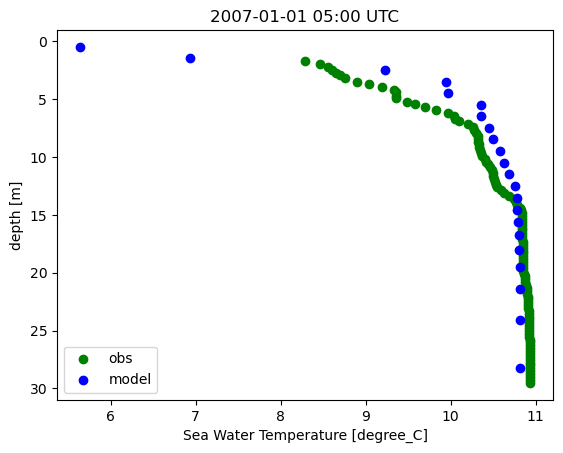

In [63]:
fig, ax = plt.subplots(1, 1)
ax.scatter(obs_sw_temps, obs_depths, color="g", label="obs")
ax.scatter(model_temp_profile, model_temp_profile.deptht, color="b", label="model")
ax.invert_yaxis()
ax.legend(loc="lower left")
profile_time = arrow.get(str(obs_sw_temps.cast_start_time.data))
ax.set_title(profile_time.format("YYYY-MM-DD HH:mm UTC"))
ax.set_ylabel(f"{obs_depths.long_name} [{obs_depths.units}]")
ax.set_xlabel(f"{obs_sw_temps.long_name} [{obs_sw_temps.units}]")

Note that the model temperature is conservative temperature while the obs temperature is in-situ
temperature. Does there need to be an adjustment applied to make them comparable?